# Desafio "Titanic: Machine Learning from Disaster" do Kaggle

  O objetivo deste Notebook é apenas para treino e aprimoramento das habilidades de Ciência de Dados do Autor. Fique a vontade para utilizado como material de estudo. Este artigo não possui intenções comerciais e nem possui relevância cientifíca, devido sua falta de originalidade perante ao meio acadêmico.

  **DESAFIO:** Construa um classificador capaz de prever se uma pessoa teria ou não sobrevivido ao desastre do Titanic.

  Link do desafio em inglês: https://www.kaggle.com/c/titanic

# Importando Pacotes do Pyhton

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from pandas.plotting import scatter_matrix
from matplotlib.pyplot import figure
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# 1. Analisando os Dados

Com o código abaixo, será carregado no nosso _Notebook_ os bancos de dados do desafio. Todos estão disponíveis para download no link do desafio fornecido anteriormente.

Os dados estão divididos em 3 arquivos .csv. O primeiro consiste nos dados de treino do nosso modelo com todas as informações relavante para o treino. O segundo consiste nos dados de teste com exceção da informação sobre a sobrevivência das vítimas. O terceiro é um conjunto de dados que apenas informa se as pessoas do segundo aruivo sobreviveu ou não ao acidente. Portanto, poderíamos aproveitar essa segregação dos dados afim de utilizar o segundo arquivo como o _input_ do nosso modelo e então usar o terceiro arquivo como o validador das previsões obtidas.

Então, é criado uma dataframe unificado de teste e serão reservados os datasets com os dados separados.



In [0]:
train_df = pd.read_csv('train.csv')
testv_df = pd.read_csv('test.csv')
testr_df = pd.read_csv('gender_submission.csv')

#Criando um DataFrame com todos os dados de teste juntos
test_df = testv_df.join(testr_df['Survived'])
test_df = test_df[["PassengerId", "Survived", "Pclass","Name", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]]

##Variáveis:

**PassengerId =**Identificador da pessoa;

**Survived =** Define se a pessoa sobreviveu ou não ao Titanic (sendo 0 como não sobrevivente e 1 como sobreviventes);

**Pclass =** Define a classe sócio-econômica da pessoa ( graduação de 1 a 3, onde 1 indica a maior classe social e 3 para a menor);

**Name =** Nome da pessoa;

**Sex =** Gênero da pessoa;

**Age =** Idade da pessoa em anos;

**SibSp =** Número de irmãos e cônjuges a pessoa tinha junto no Titanic;

**Parch =** Número de pais e filhos a pessoa tinha junto no Titanic;

**Ticket =** Número do ticket;

**Fare =** Tarifa do passageiro;

**Cabin =** Número da cabine;

**Embarked =** Indica o porto de embarcação (C = Cherbourg, Q = Queenstown e S = Southampton);

## Visualização dos DataFrames

### 1.1. Dados de Treino:

In [3]:
n_train = train_df.shape
print('Total de dados de treino:', n_train[0])

Total de dados de treino: 891


In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_null = train_df.isnull()
train_nullp = train_null.sum() / n_train[0]
print(train_nullp)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64


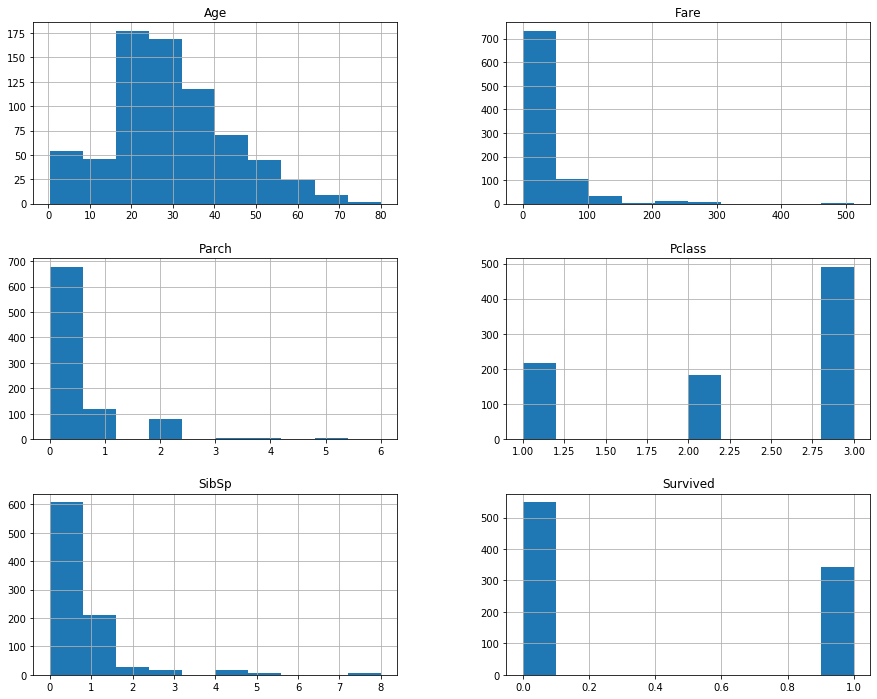

In [7]:
train_withoutid_df = train_df.drop('PassengerId', axis = 1)
train_withoutid_df.hist(figsize = (15, 12))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe267135518>,
      dtype=object)

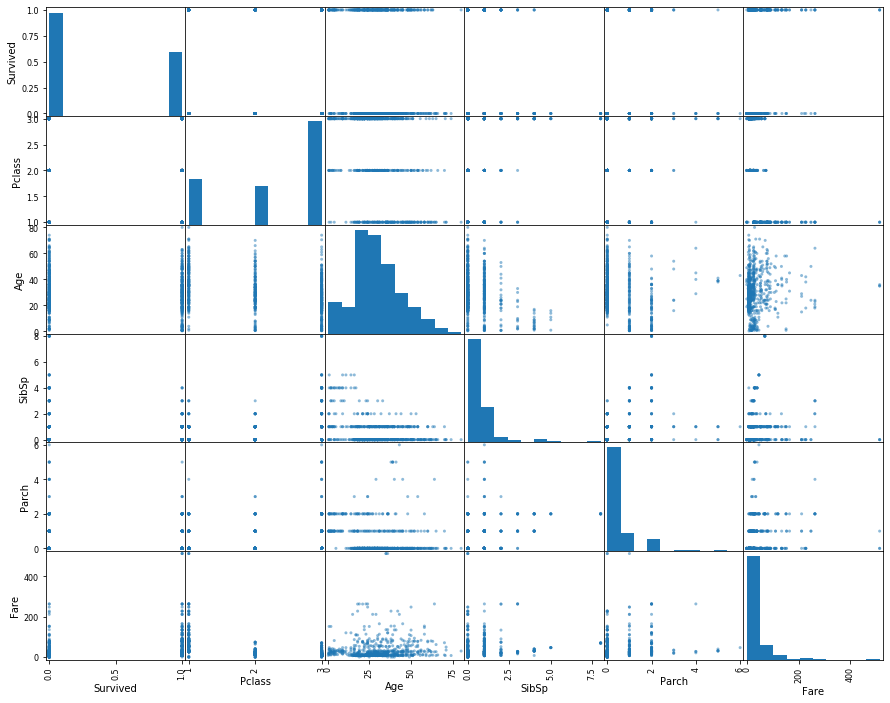

In [8]:
train_attributes = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]
scatter_matrix(train_withoutid_df[train_attributes], figsize = (15,12))

In [9]:
train_corr_matrix = train_withoutid_df.corr()
train_corr_matrix["Survived"].sort_values(ascending = False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

Como podemos observar, temos 891 dados nesse conjunto de dados de treino. Além disso, existem variáveis com dados em branco ou nulos: Age, Cabin e Embarked.

Futuramente será necessário preencher esses valores de forma que não afete as propriedades estatísticas do grupo como um todo. Porém, pode-se até fazer necessário excluir completamente as colunas pela imensa falta de valores, como é o caso da coluna Cabin que tem mais da metade dos seus valores nulos.

Quando verificados os histogramas das variáveis, pode-se notar a presenção de outliers em algumas variáveis como: Fare, Parch e SibSp. Isso é evidenciado pelos altos valores de desvio padrão destas variáveis. Com isso, é importante observar a performance do modelo quanto a estas variáveis, pois ela pode estar sucetível a dar parâmetros imprecisos.

Por fim, através do gráfico de dispensão e com a matrix de correlações é possível notar que as variáveis não tem um correlação muito grande com a chance de sobrevivência. Entretanto, uma pequena correlação existe com as tarifas e a classe social quando comparada com a sobrevivência, idicando que pessoas mais ricas tenderam a sobreviverão desastre. Entretanto, a correlação pequena não faz com que possamos confirmar isso estatisticamente por enquanto.

### 1.2. Dados de Teste:

In [10]:
n_test = test_df.shape
print('Total de dados de treino:', n_test[0])

Total de dados de treino: 418


In [11]:
test_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [12]:
test_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,0.363636,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.481622,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,0.000000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,0.000000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,1.000000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [13]:
test_null = test_df.isnull()
test_nullp = test_null.sum() / n_test[0]
print(test_nullp)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64


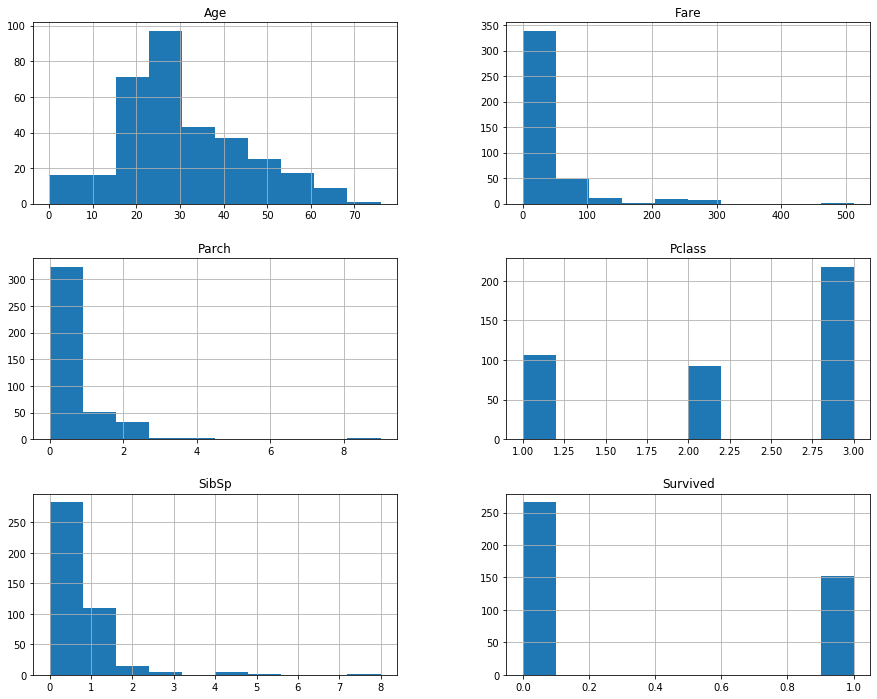

In [14]:
test_withoutid_df = test_df.drop('PassengerId', axis = 1)
test_withoutid_df.hist(figsize = (15, 12))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2620059b0>,
      dtype=object)

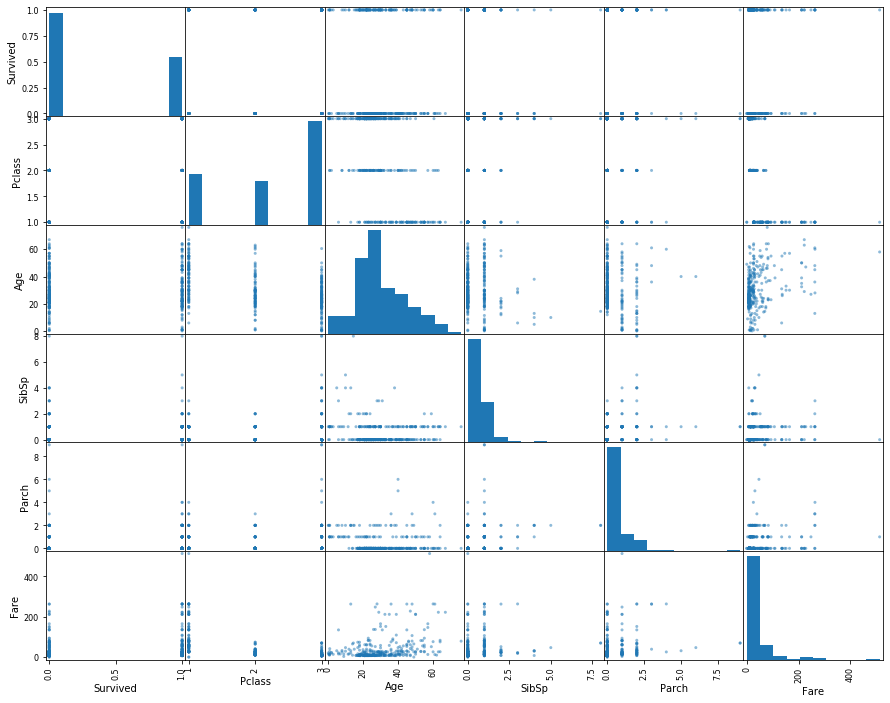

In [15]:
test_attributes = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]
scatter_matrix(test_withoutid_df[test_attributes], figsize = (15,12))

Pode-se notar que temos 418 dados de teste e eles podem propriedades estatísticas muito similares ao conjunto de treino. Isso é ótimo pois não precisamos redistribuir dos dados nestes dois conjuntos afim de ter um modelo mais preciso. Portanto, também se tem as mesmas conclusões que os dados de treino.

# 2. Preprocessando os Dados para os Algoritmos de Machine Learning


Para poder continuar a elaboração do modelo, é preciso limpar o conjunto de dados. Observando o conjunto de dados, é possível notar que pode-se simplificar a análise do classificador retirando o nome (Name) e o "número" do ticket (Ticket). Esses valores além de parecerem não impactar diretamente na previsão do sobreviventes, são valores exatamente vairados entre os dados sendo difícil de se ter uma correlação entre eles. 

Além disso, existem muitos dados faltantes que podem (e provavelmente irão) tornar nosso modelo impreciso. Em especial, se destaca a grande falta de dados na variável das cabinas com mais de 50% dos dados faltando. Talvez seja interessante retirar essa coluna do DataFrame. 

Para facilitar a análise, serão criados Pipeline a fim de automatizar e padronizar a transformização de dados (numéricos e textuais) neste modelo.

In [0]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [0]:
pipeline_num = Pipeline([
                         ("select_num", DataFrameSelector(["Pclass", "Age", "SibSp", "Parch", "Fare"])),
                         ("imputer", SimpleImputer(missing_values = np.nan, strategy = "median")),
])

In [0]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [0]:
pipeline_cat = Pipeline([
                         ("select_cat", DataFrameSelector(["Sex", "Embarked"])),
                         ("imputer", MostFrequentImputer()),
                         ("cat_encoder", OneHotEncoder(sparse = False)),
])

Criados os processos para os dados numéricos e textuais, agora podemos juntar os dois:

In [0]:
pipeline_total = FeatureUnion (transformer_list = [
                                                   ("pipeline_num", pipeline_num),
                                                   ("pipeline_cat", pipeline_cat),
])

In [0]:
X_train = pipeline_total.fit_transform(train_df)
X_test = pipeline_total.fit_transform(test_df)

y_train = train_df["Survived"]
y_test = test_df["Survived"]

In [22]:
pd.DataFrame(X_train).isnull().any()

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
dtype: bool

# 3. Gerando o Modelo

Agora com nossos dados limpos, podemos começar a gerar modelos e fazer previsões. Para nosso primeiro teste, utilizaremos o SVC.

In [23]:
svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_predict = svm_clf.predict(X_test)

In [25]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv = 10)
svm_scores.mean()

0.7307365792759051

Com esse modelo, acertamos em 73,1% dos casos. Porém, podemos melhorar a precisão usando o modelo de Forestas Aleatórias:

In [26]:
rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=1)
rf_clf.fit(X_train, y_train)
rf_scores = cross_val_score(rf_clf, X_train, y_train, cv =10)
rf_scores.mean()

0.8305493133583021

In [29]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) +  1
print(d)

2
